<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/vitaldb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using VitalDB open dataset 

All users who use VitalDB, an open biosignal dataset, must agree to the Data Use Agreement below. 

https://vitaldb.net/data-bank/?query=guide&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.usmoena3l4rb

If you do not agree, please close this window.

# Loading library and data

To use the VitalDB open dataset, the pandas library is required.

At first, we need to load 3 endpoints of the VitalDB open dataset. 

In [1]:
import pandas as pd

df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # clinical information
df_trks = pd.read_csv("https://api.vitaldb.net/trks")  # track list
df_labs = pd.read_csv('https://api.vitaldb.net/labs')  # laboratory results

## Using clinical information data
Let's visually check the cases and variables of the VitalDB dataset.

In [2]:
df_cases

,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,icu_days,death_inhosp,age,sex,height,weight,bmi,asa,emop,department,optype,dx,opname,approach,position,ane_type,preop_htn,preop_dm,preop_ecg,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_gluc,preop_alb,preop_ast,preop_alt,preop_bun,preop_cr,preop_ph,preop_hco3,preop_be,preop_pao2,preop_paco2,preop_sao2,cormack,airway,tubesize,dltubesize,lmasize,iv1,iv2,aline1,aline2,cline1,cline2,intraop_ebl,intraop_uo,intraop_rbc,intraop_ffp,intraop_crystalloid,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
0,1,5955,0,11520,-540,10860,-540,10380,-236220,627780,0,0,77.0,M,160.2,67.50,26.3,2.0,0,General surgery,Colorectal,Rectal cancer,Low anterior resection,Open,Lithotomy,General,1,0,Normal Sinus Rhythm,Normal,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,NaN,Left radial,NaN,NaN,NaN,NaN,300.0,0,0,350.0,0,120,0.0,100,70,0,10,0,0,0
1,2,2487,0,15720,-1020,14940,1740,14640,-221160,1506840,0,0,54.0,M,167.3,54.80,19.6,2.0,0,General surgery,Stomach,Advanced gastric cancer,Subtotal gastrectomy,Open,Supine,General,0,0,Normal Sinus Rhythm,Normal,10.2,251.0,110.0,31.9,143.0,4.7,88.0,3.8,18.0,15.0,14.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,NaN,NaN,NaN,NaN,NaN,50.0,700.0,0,0,800.0,0,150,0.0,0,100,0,20,0,0,0
2,3,2861,0,4440,-540,4260,-540,3960,-218640,40560,0,0,62.0,M,169.1,69.70,24.4,1.0,0,General surgery,Biliary/Pancreas,Gallbladder stone,Cholecystectomy,Videoscopic,Reverse Trendelenburg,General,0,0,Normal Sinus Rhythm,Normal,14.2,373.0,103.0,30.3,144.0,4.9,87.0,4.2,17.0,34.0,14.0,1.18,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,200.0,0,0,0.0,0,50,0,0,0,0,0
3,4,1903,0,21000,-720,20280,2580,18180,-201120,576480,1,0,74.0,M,160.6,53.00,20.5,2.0,0,General surgery,Stomach,Advanced gastric cancer,Distal gastrectomy,Videoscopic,Reverse Trendelenburg,General,1,0,Normal Sinus Rhythm,Normal,14.4,275.0,103.0,34.5,141.0,4.2,108.0,4.1,23.0,18.0,10.0,0.96,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,NaN,NaN,NaN,Left forearm,NaN,Right radial,NaN,NaN,NaN,NaN,270.0,0,0,2700.0,0,80,0.0,100,100,0,50,0,0,0
4,5,4416,0,21540,-960,22440,2640,21840,-67560,3734040,13,0,66.0,M,171.0,59.70,20.4,3.0,1,General surgery,Vascular,Aortic aneurysm,Aneurysmal repair,Open,Prone,General,1,0,Left anterior fascicular block,Normal,10.1,67.0,73.0,36.5,146.0,4.4,126.0,2.6,765.0,77.0,50.0,4.43,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,NaN,Right radial,NaN,Right IJV,NaN,2600.0,1490.0,8,8,7100.0,0,0,0.0,0,160,0,10,900,0,2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383,6384,5583,0,15240,-240,15660,-240,15060,-215340,648660,0,0,64.0,M,161.5,63.00,24.2,1.0,0,General surgery,Stomach,Advanced gastric cancer,Total gastrectomy,Open,Supine,General,0,0,Normal Sinus Rhythm,Normal,14.5,279.0,109.0,31.0,NaN,NaN,100.0,4.2,31.0,33.0,13.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,NaN,NaN,NaN,NaN,NaN,100.0,330.0,0,0,550.0,0,150,0.0,0,90,0,20,0,0,0
6384,6385,2278,0,20640,-540,21000,-540,19800,-225600,1675200,0,0,69.0,M,159.3,62.30,24.6,2.0,0,General surgery,Colorectal,"Colon submucosal tumor, unknown behavior",Ultralow anterior resection,Videoscopic,Lithotomy,General,1,0,Normal Sinus Rhythm,Normal,15.2,239.0,114.0,28.7,144.0,4.0,140.0,3.7,18.0,28.0,19.0,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,NaN,NaN,Right forearm,Left forearm,Right radial,NaN,NaN,NaN,100.0,250.0,0,0,2500.0,0,100,0.0,0,100,0,25,30,0,300
6385,6386,4045,0,19440,-660,19140,3540,18540,-200460,836340,0,0,61.0,F,151.7,43.25,18.8,1.0,0,General surgery,Stomach,Early gas

Then, check the clinical information missing rate.

In [3]:
print((df_cases.isnull().mean() * 100).to_string())

caseid                  0.000000
subjectid               0.000000
casestart               0.000000
caseend                 0.000000
anestart                0.000000
aneend                  0.000000
opstart                 0.000000
opend                   0.000000
adm                     0.000000
dis                     0.000000
icu_days                0.000000
death_inhosp            0.000000
age                     0.000000
sex                     0.000000
height                  0.000000
weight                  0.000000
bmi                     0.000000
asa                     2.082029
emop                    0.000000
department              0.000000
optype                  0.000000
dx                      0.000000
opname                  0.000000
approach                0.000000
position                3.036944
ane_type                0.000000
preop_htn               0.000000
preop_dm                0.000000
preop_ecg               0.000000
preop_pft               0.000000
preop_hb  

More examples using clinical information data in VitalDB are as below.


*   https://github.com/vitaldb/examples/blob/master/asa_mortality.ipynb
*   https://github.com/vitaldb/examples/blob/master/predict_mortality.ipynb



## Using track list data

In [4]:
df_trks

,caseid,tname,tid
0,1,BIS/BIS,fd869e25ba82a66cc95b38ed47110bf4f14bb368
1,1,BIS/EEG1_WAV,0aa685df768489a18a5e9f53af0d83bf60890c73
2,1,BIS/EEG2_WAV,ad13b2c39b19193c8ae4a2de4f8315f18d61a57e
3,1,BIS/EMG,2525603efe18d982764dbca457affe7a45e766a9
4,1,BIS/SEF,1c91aec859304840dec75acf4a35da78be0e8ef0
...,...,...,...
486444,6388,Solar8000/VENT_PIP,2d63adbc7e2653f14348e219816673cde3358cf6
486445,6388,Solar8000/VENT_PPLAT,6f6604255858ddc8f6a01b9f4774b0d43105f6da
486446,6388,Solar8000/VENT_RR,f34f3fae7fd963355c1c7060e1e876d20fa87536
486447,6388,Solar8000/VENT_SET_TV,4a4a55b8aebf9c76a4a76f62a7c1ec6fcb80e618


Then, check the clinical information missing rate.

In [ ]:
print('{} track types'.format(len(df_trks['tname'].unique())))
for tname in sorted(df_trks['tname'].unique()):
    print('{}\t{}'.format(tname, (df_trks['tname'] == tname).sum() / len(df_cases) * 100))


196 track types
BIS/BIS	91.84408265497808
BIS/EEG1_WAV	91.9067000626174
BIS/EEG2_WAV	91.9067000626174
BIS/EMG	87.30432060112712
BIS/SEF	87.17908578584847
BIS/SQI	91.84408265497808
BIS/SR	87.17908578584847
BIS/TOTPOW	86.8973074514715
CardioQ/ABP	0.4539762053850971
CardioQ/CI	0.4383218534752661
CardioQ/CO	0.4539762053850971
CardioQ/FLOW	0.4539762053850971
CardioQ/FTc	0.4539762053850971
CardioQ/FTp	0.4383218534752661
CardioQ/HR	0.4539762053850971
CardioQ/MA	0.4383218534752661
CardioQ/MD	0.4539762053850971
CardioQ/PV	0.4383218534752661
CardioQ/SD	0.4539762053850971
CardioQ/SV	0.4539762053850971
CardioQ/SVI	0.4383218534752661
EV1000/ART_MBP	9.267376330619912
EV1000/CI	9.658735128365684
EV1000/CO	9.658735128365684
EV1000/CVP	3.678772698810269
EV1000/SV	9.658735128365684
EV1000/SVI	9.658735128365684
EV1000/SVR	3.991859737006888
EV1000/SVRI	3.991859737006888
EV1000/SVV	9.658735128365684
FMS/FLOW_RATE	0.234815278647464
FMS/INPUT_AMB_TEMP	0.234815278647464
FMS/INPUT_TEMP	0.234815278647464
FMS/OU

## Using laboratory results data

In [5]:
print('{} lab types'.format(len(df_labs['name'].unique())))
df_labs

34 lab types


,caseid,dt,name,result
0,1,594470,alb,2.90
1,1,399575,alb,3.20
2,1,12614,alb,3.40
3,1,137855,alb,3.60
4,1,399575,alt,12.00
...,...,...,...,...
928443,6388,3503,sao2,100.00
928444,6388,408770,wbc,3.28
928445,6388,-32848,wbc,6.27
928446,6388,-249820,wbc,7.66


# Research process using VitalDB open dataset 


## Find a case that satisfies a specific condition

The beginning of the research using VitalDB data is to find cases that meet the inclusion and exclusion criteria. The code below is an example of doing this.

In [6]:
df_cases[df_cases['opname'].str.contains("transplant")]

,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,icu_days,death_inhosp,age,sex,height,weight,bmi,asa,emop,department,optype,dx,opname,approach,position,ane_type,preop_htn,preop_dm,preop_ecg,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_gluc,preop_alb,preop_ast,preop_alt,preop_bun,preop_cr,preop_ph,preop_hco3,preop_be,preop_pao2,preop_paco2,preop_sao2,cormack,airway,tubesize,dltubesize,lmasize,iv1,iv2,aline1,aline2,cline1,cline2,intraop_ebl,intraop_uo,intraop_rbc,intraop_ffp,intraop_crystalloid,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
11,12,491,0,31200,-180,31500,-180,30900,-208500,1519500,4,0,46.0,F,169.2,81.4,28.4,2.0,0,General surgery,Transplantation,Hepatocellular carcinoma,Liver transplantation,Open,Supine,General,0,0,Normal Sinus Rhythm,Normal,9.2,67.0,56.0,39.3,140.0,3.6,93.0,3.1,25.0,15.0,6.0,0.58,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.0,NaN,NaN,Right forearm,NaN,Right radial,NaN,Right IJV,NaN,1300.0,1280.0,0,0,4800.0,200,100,0.0,100,70,0,20,0,0,3300
51,52,1724,0,15600,-1440,15660,-1440,15060,-220140,1075860,0,0,44.0,M,173.5,67.3,22.4,3.0,0,General surgery,Transplantation,End stage renal disease,Kidney transplantation,Open,Supine,General,1,0,Normal Sinus Rhythm,Normal,11.0,216.0,132.0,35.8,141.0,4.3,85.0,4.0,20.0,15.0,57.0,7.34,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,NaN,Right radial,NaN,Right IJV,NaN,NaN,550.0,0,0,2900.0,35,0,0.0,0,120,0,0,0,0,0
54,55,5077,0,21720,-720,22500,3600,21900,-210900,1603500,3,0,18.0,M,175.1,59.2,19.3,2.0,0,General surgery,Transplantation,Liver cirrhosis Unspecified,Liver transplantation,Open,Supine,General,0,0,Normal Sinus Rhythm,Normal,13.1,92.0,52.0,47.8,142.0,3.4,134.0,3.4,17.0,15.0,7.0,0.50,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,NaN,Right radial,Right femoral,Right IJV,NaN,500.0,290.0,0,0,4100.0,100,0,0.0,0,50,0,20,0,0,1200
57,58,5141,0,14760,-180,14820,-180,14520,-153180,1056420,1,0,42.0,F,169.7,57.8,20.1,3.0,0,General surgery,Transplantation,End stage renal disease,Kidney transplantation,Open,Supine,General,1,0,Normal Sinus Rhythm,Normal,11.1,176.0,144.0,29.5,132.0,5.4,92.0,3.6,26.0,15.0,73.0,15.15,7.471,NaN,NaN,NaN,NaN,NaN,I,Oral,7.0,NaN,NaN,Left forearm,NaN,Right radial,NaN,Right IJV,NaN,420.0,200.0,0,0,2100.0,35,120,0.0,100,60,0,20,0,0,600
59,60,4115,0,14280,-1740,13560,1560,12960,-223440,1158960,0,0,55.0,F,157.0,46.8,19.0,2.0,1,General surgery,Transplantation,end stage renal disease,Kidney transplantation,Open,Supine,General,1,0,Normal Sinus Rhythm,Borderline obstructive,11.4,138.0,123.0,27.6,140.0,4.1,82.0,3.7,22.0,16.0,34.0,6.70,7.434,23.3,-1.3,104.0,33.5,98.8,I,Oral,7.0,NaN,NaN,Right forearm,NaN,Right radial,NaN,Right IJV,NaN,200.0,420.0,0,0,1700.0,35,0,0.0,0,70,0,0,0,0,600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6296,6297,4900,0,26220,-300,26700,3900,26700,-385500,996900,4,0,63.0,F,153.9,61.4,25.9,NaN,1,General surgery,Transplantation,Liver cirrhosis with hepatitis C Child-Pugh C,Liver transplantation,Open,Supine,General,0,0,Normal Sinus Rhythm,Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.0,NaN,NaN,Left forearm,NaN,Right radial,Right femoral,Right IJV,Right IJV,800.0,200.0,2,3,4500.0,400,0,0.0,0,70,0,0,0,75,1800
6336,6337,5565,0,24240,-420,25680,-420,25380,-1286520,1391880,17,1,0.4,F,54.0,4.8,16.5,3.0,1,General surgery,Transplantation,Hepatic failure without coma,Liver transplantation,Open,Supine,General,0,0,Normal Sinus Rhythm,Normal,8.5,105.0,24.0,104.7,139.0,3.9,79.0,2.7,673.0,94.0,9.0,0.22,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,3.0,NaN,NaN,Left forearm,NaN,Right femoral,NaN,Right IJV,NaN,150.0,5.0,0,0,80.0,20,0,0.0,0,3,0,0,0,

In [ ]:
caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) & 
    set(df_cases[df_cases['age'] > 18]['caseid']) & 
    set(df_cases[False == df_cases['opname'].str.contains("transplant")]['caseid'])
)
print(len(caseids))

3452


## Load the desired track from Case ID

The next step is to load the actual track data with caseid and track name. Using the vitaldb library is the simplest way.

In [ ]:
!wget https://raw.githubusercontent.com/vitaldb/vitalutils/master/python/vitaldb.py

--2021-07-08 01:35:08--  https://raw.githubusercontent.com/vitaldb/vitalutils/master/python/vitaldb.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19378 (19K) [text/plain]
Saving to: ‘vitaldb.py’

vitaldb.py          100%[===================>]  18.92K  --.-KB/s    in 0s      

2021-07-08 01:35:09 (78.8 MB/s) - ‘vitaldb.py’ saved [19378/19378]



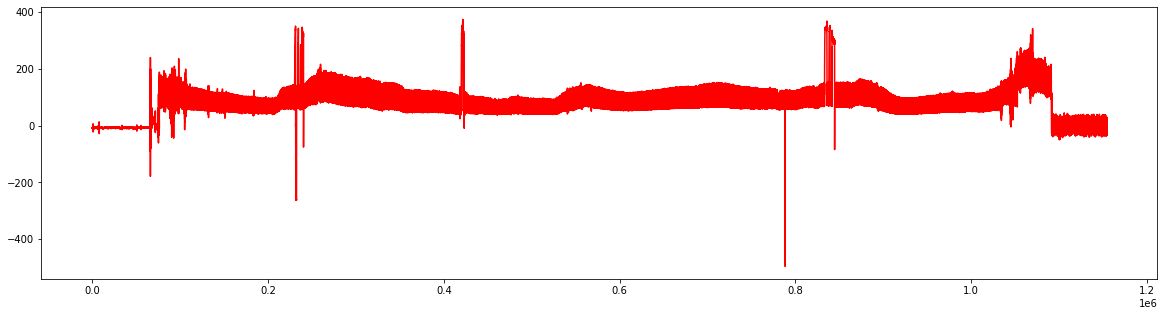

In [ ]:
import vitaldb
trks = vitaldb.load_case(['SNUADC/ART','Solar8000/ART_SBP'], caseid=1, interval=1/100)

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(trks[:, 0], color='r')
plt.show()